In [40]:
import os

def get_all_tifs(root_dir):
    tif_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".tif"):
                tif_paths.append(os.path.join(root, file))
    return sorted(tif_paths)

all_files = get_all_tifs(ROOT)
print("Total tif files found:", len(all_files))

Total tif files found: 3333


In [39]:
import os

ROOT = "/Users/ramupadhyay/Desktop/thermal4"

print(os.listdir(ROOT)[:10])

['0006912', '0002748', '0022941', '0019764', '0000649', '0002922', '0015995', '0026516', '0018817', '0001562']


In [41]:
import random

random.seed(42)
random.shuffle(all_files)

split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]

print("Train:", len(train_files))
print("Val:", len(val_files))

Train: 2666
Val: 667


In [42]:
OLI_BANDS = 9
TIRS_BANDS = 2

In [43]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

import numpy as np
import rasterio
import random
import os
from tqdm import tqdm


In [44]:
PATCH_SIZE = 64

def load_random_patch(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)

    for c in range(img.shape[0]):
        low, high = np.percentile(img[c], [2, 98])
        if high > low:
            img[c] = (img[c] - low) / (high - low)
        else:
            img[c] = img[c] / (img[c].max() + 1e-6) # Fallback for flat patches

    img = np.clip(img, 0, 1) # Force everything into the 0-1 range

    # 2. PATCHING
    C, H, W = img.shape
    x = np.random.randint(0, H - PATCH_SIZE)
    y = np.random.randint(0, W - PATCH_SIZE)
    patch = img[:, x:x+PATCH_SIZE, y:y+PATCH_SIZE]

    oli = patch[:9]
    tirs = patch[9:] # Usually bands 10 & 11

    return oli, tirs


In [45]:
def get_batch(file_list, batch_size=8):
    oli_batch = []
    tirs_batch = []

    for _ in range(batch_size):
        path = random.choice(file_list)
        oli, tirs = load_random_patch(path)

        oli_batch.append(oli)
        tirs_batch.append(tirs)

    oli_batch = np.stack(oli_batch)
    tirs_batch = np.stack(tirs_batch)

# Convert NCHW → NHWC
    oli_batch = np.transpose(oli_batch, (0, 2, 3, 1))
    tirs_batch = np.transpose(tirs_batch, (0, 2, 3, 1))

    oli_batch = mx.array(oli_batch)
    tirs_batch = mx.array(tirs_batch)

    return oli_batch, tirs_batch

In [46]:
class ThermalSR(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(9, 64, 3, padding=1)
        self.relu = nn.ReLU()
        
        self.res1 = nn.Conv2d(64, 64, 3, padding=1)
        self.res2 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.conv_out = nn.Conv2d(64, 2, 3, padding=1)

    def __call__(self, x):
        x = self.relu(self.conv1(x))
        
        residual = x
        
        x = self.relu(self.res1(x))
        x = self.res2(x)
        
        x = x + residual
        
        x = self.conv_out(x)
        
        return x

In [47]:
model = ThermalSR()
optimizer = optim.Adam(learning_rate=5e-5)


In [48]:
def mse_loss(pred, target):
    return mx.mean((pred - target) ** 2)

In [49]:
def psnr(pred, target):
    mse = mx.mean((pred - target) ** 2)
    return 20 * mx.log10(1.0 / mx.sqrt(mse + 1e-8))

In [50]:
import numpy as np
import matplotlib.pyplot as plt
EPOCHS = 50   # test first
BATCH_SIZE = 8
STEPS_PER_EPOCH = 200

best_val_loss = float("inf")

def loss_fn(oli_batch, tirs_batch):
    pred = model(oli_batch)
    return mx.mean((pred - tirs_batch) ** 2)

loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

train_losses = []
val_losses = []
val_psnrs = []


for epoch in range(EPOCHS):

    train_loss = 0

    for _ in tqdm(range(STEPS_PER_EPOCH)):
        oli_batch, tirs_batch = get_batch(train_files, BATCH_SIZE)

        # Forward + backward in one step
        loss, grads = loss_and_grad_fn(oli_batch, tirs_batch)

        optimizer.update(model, grads)

        mx.eval(model.parameters(), optimizer.state)

        train_loss += loss.item()

    train_loss /= STEPS_PER_EPOCH

    # Validation
    val_loss = 0
    val_psnr = 0

    for _ in range(50):
        oli_batch, tirs_batch = get_batch(val_files, BATCH_SIZE)
        pred = model(oli_batch)

        val_loss += mse_loss(pred, tirs_batch).item()
        val_psnr += psnr(pred, tirs_batch).item()

    val_loss /= 50
    val_psnr /= 50

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_psnrs.append(val_psnr)

    improvement = ((val_psnrs[-1] - val_psnrs[0]) / val_psnrs[0]) * 100
    print(f"PSNR Improvement: {improvement:.2f}%")
    loss_reduction = ((train_losses[0] - train_losses[-1]) / train_losses[0]) * 100
    print(f"Loss Reduced by: {loss_reduction:.2f}%")


    print(f"\nEpoch {epoch+1}")
    print("Train Loss:", train_loss)
    print("Val Loss:", val_loss)
    print("Val PSNR:", val_psnr)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        params = model.parameters()
        np.savez("best_model.npz", **params)
        print("Model saved!")

100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.76it/s]


PSNR Improvement: 0.00%
Loss Reduced by: 0.00%

Epoch 1
Train Loss: 0.08047795197926462
Val Loss: 0.056556910946965216
Val PSNR: 12.794907836914062
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.88it/s]


PSNR Improvement: -2.56%
Loss Reduced by: 28.91%

Epoch 2
Train Loss: 0.057213338362053036
Val Loss: 0.05966777607798576
Val PSNR: 12.467295570373535


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.72it/s]


PSNR Improvement: 2.25%
Loss Reduced by: 33.45%

Epoch 3
Train Loss: 0.053560480391606685
Val Loss: 0.053178977705538276
Val PSNR: 13.08300687789917
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 11.10it/s]


PSNR Improvement: 5.78%
Loss Reduced by: 37.91%

Epoch 4
Train Loss: 0.04997019470669329
Val Loss: 0.04782777963206172
Val PSNR: 13.5348486328125
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.66it/s]


PSNR Improvement: 7.53%
Loss Reduced by: 38.06%

Epoch 5
Train Loss: 0.04984781549312174
Val Loss: 0.04511631365865469
Val PSNR: 13.758676319122314
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.58it/s]


PSNR Improvement: 9.19%
Loss Reduced by: 40.58%

Epoch 6
Train Loss: 0.04781692788004875
Val Loss: 0.04246127411723137
Val PSNR: 13.97012092590332
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.64it/s]


PSNR Improvement: 3.71%
Loss Reduced by: 40.82%

Epoch 7
Train Loss: 0.04762954699806869
Val Loss: 0.0493938085436821
Val PSNR: 13.269434890747071


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.24it/s]


PSNR Improvement: 5.31%
Loss Reduced by: 41.86%

Epoch 8
Train Loss: 0.046787454066798094
Val Loss: 0.04756855584681034
Val PSNR: 13.474384307861328


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.34it/s]


PSNR Improvement: 8.30%
Loss Reduced by: 43.61%

Epoch 9
Train Loss: 0.04538472817279399
Val Loss: 0.04367506381124258
Val PSNR: 13.857179603576661


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.58it/s]


PSNR Improvement: 7.80%
Loss Reduced by: 46.04%

Epoch 10
Train Loss: 0.043421964487060906
Val Loss: 0.04470238491892815
Val PSNR: 13.792868061065674


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.73it/s]


PSNR Improvement: 7.08%
Loss Reduced by: 45.96%

Epoch 11
Train Loss: 0.043487924803048375
Val Loss: 0.04641958249732852
Val PSNR: 13.700480041503907


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.65it/s]


PSNR Improvement: 7.97%
Loss Reduced by: 42.28%

Epoch 12
Train Loss: 0.04644965000450611
Val Loss: 0.04407785557210445
Val PSNR: 13.815282802581788


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.24it/s]


PSNR Improvement: 10.45%
Loss Reduced by: 46.98%

Epoch 13
Train Loss: 0.042671996569260955
Val Loss: 0.041485936604440214
Val PSNR: 14.131378517150878
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.27it/s]


PSNR Improvement: 10.27%
Loss Reduced by: 45.02%

Epoch 14
Train Loss: 0.044249645788222554
Val Loss: 0.040889968387782576
Val PSNR: 14.108416423797607
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.39it/s]


PSNR Improvement: 9.97%
Loss Reduced by: 46.94%

Epoch 15
Train Loss: 0.04270175603218376
Val Loss: 0.04285477455705404
Val PSNR: 14.069945125579833


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.50it/s]


PSNR Improvement: 7.05%
Loss Reduced by: 44.92%

Epoch 16
Train Loss: 0.0443279320653528
Val Loss: 0.046334706246852875
Val PSNR: 13.696908168792724


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.02it/s]


PSNR Improvement: 9.52%
Loss Reduced by: 47.42%

Epoch 17
Train Loss: 0.04231692323461175
Val Loss: 0.043168832063674924
Val PSNR: 14.013081226348877


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.37it/s]


PSNR Improvement: 10.35%
Loss Reduced by: 49.43%

Epoch 18
Train Loss: 0.04069964305497706
Val Loss: 0.04120468981564045
Val PSNR: 14.118898696899414


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.82it/s]


PSNR Improvement: 7.60%
Loss Reduced by: 48.93%

Epoch 19
Train Loss: 0.041098627736791966
Val Loss: 0.04506474588066339
Val PSNR: 13.767837753295899


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.74it/s]


PSNR Improvement: 7.83%
Loss Reduced by: 50.36%

Epoch 20
Train Loss: 0.03994952751789242
Val Loss: 0.043863984383642675
Val PSNR: 13.796710891723633


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.23it/s]


PSNR Improvement: 12.50%
Loss Reduced by: 48.04%

Epoch 21
Train Loss: 0.041813128516078
Val Loss: 0.03879160374403
Val PSNR: 14.394539318084718
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.54it/s]


PSNR Improvement: 12.62%
Loss Reduced by: 47.33%

Epoch 22
Train Loss: 0.04239140103105456
Val Loss: 0.03832736529409885
Val PSNR: 14.409291305541991
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.50it/s]


PSNR Improvement: 11.93%
Loss Reduced by: 48.67%

Epoch 23
Train Loss: 0.04130581743083894
Val Loss: 0.03936491694301367
Val PSNR: 14.32141616821289


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.72it/s]


PSNR Improvement: 12.38%
Loss Reduced by: 52.16%

Epoch 24
Train Loss: 0.03850284535437822
Val Loss: 0.038594900369644164
Val PSNR: 14.379256172180176


100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.98it/s]


PSNR Improvement: 9.67%
Loss Reduced by: 49.76%

Epoch 25
Train Loss: 0.04042863558512181
Val Loss: 0.04213305626064539
Val PSNR: 14.032225418090821


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.04it/s]


PSNR Improvement: 10.42%
Loss Reduced by: 47.98%

Epoch 26
Train Loss: 0.0418675162550062
Val Loss: 0.04268554773181677
Val PSNR: 14.127674980163574


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.58it/s]


PSNR Improvement: 11.26%
Loss Reduced by: 48.66%

Epoch 27
Train Loss: 0.04131462364457548
Val Loss: 0.039284395687282085
Val PSNR: 14.235049953460694


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.31it/s]


PSNR Improvement: 9.77%
Loss Reduced by: 49.41%

Epoch 28
Train Loss: 0.040709801204502585
Val Loss: 0.04217197179794312
Val PSNR: 14.04486722946167


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.24it/s]


PSNR Improvement: 11.14%
Loss Reduced by: 49.10%

Epoch 29
Train Loss: 0.040964646190404894
Val Loss: 0.04118586858734488
Val PSNR: 14.219706783294678


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.86it/s]


PSNR Improvement: 14.21%
Loss Reduced by: 49.44%

Epoch 30
Train Loss: 0.04069050640799105
Val Loss: 0.03694350615143776
Val PSNR: 14.612626495361328
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.76it/s]


PSNR Improvement: 15.00%
Loss Reduced by: 52.18%

Epoch 31
Train Loss: 0.03848165884613991
Val Loss: 0.03636795651167631
Val PSNR: 14.714556999206543
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.62it/s]


PSNR Improvement: 13.59%
Loss Reduced by: 49.51%

Epoch 32
Train Loss: 0.04063334485515952
Val Loss: 0.037711146622896194
Val PSNR: 14.534176368713378


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.45it/s]


PSNR Improvement: 10.04%
Loss Reduced by: 49.20%

Epoch 33
Train Loss: 0.0408851907774806
Val Loss: 0.04162291895598173
Val PSNR: 14.080149459838868


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.07it/s]


PSNR Improvement: 12.21%
Loss Reduced by: 52.54%

Epoch 34
Train Loss: 0.038191123325377704
Val Loss: 0.03916175454854965
Val PSNR: 14.356912517547608


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.18it/s]


PSNR Improvement: 8.41%
Loss Reduced by: 51.66%

Epoch 35
Train Loss: 0.0389021203154698
Val Loss: 0.04429763507097959
Val PSNR: 13.870800838470458


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.82it/s]


PSNR Improvement: 12.78%
Loss Reduced by: 51.44%

Epoch 36
Train Loss: 0.03907978107221424
Val Loss: 0.040534772425889966
Val PSNR: 14.429857406616211


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.80it/s]


PSNR Improvement: 14.65%
Loss Reduced by: 51.87%

Epoch 37
Train Loss: 0.038736410071142015
Val Loss: 0.036026363670825956
Val PSNR: 14.669526271820068
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.37it/s]


PSNR Improvement: 13.45%
Loss Reduced by: 51.56%

Epoch 38
Train Loss: 0.03898690754547715
Val Loss: 0.038871902786195275
Val PSNR: 14.515647163391113


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.50it/s]


PSNR Improvement: 11.22%
Loss Reduced by: 51.95%

Epoch 39
Train Loss: 0.038668883619830015
Val Loss: 0.040718702450394634
Val PSNR: 14.2306201171875


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.55it/s]


PSNR Improvement: 15.46%
Loss Reduced by: 53.13%

Epoch 40
Train Loss: 0.03772101609967649
Val Loss: 0.03595832332968712
Val PSNR: 14.77311689376831
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.39it/s]


PSNR Improvement: 12.54%
Loss Reduced by: 52.87%

Epoch 41
Train Loss: 0.03793124870397151
Val Loss: 0.03875237889587879
Val PSNR: 14.39937801361084


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.30it/s]


PSNR Improvement: 12.24%
Loss Reduced by: 51.44%

Epoch 42
Train Loss: 0.03907621991820633
Val Loss: 0.0393569653481245
Val PSNR: 14.360697765350341


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.13it/s]


PSNR Improvement: 15.79%
Loss Reduced by: 53.83%

Epoch 43
Train Loss: 0.03715412608347833
Val Loss: 0.03572539187967777
Val PSNR: 14.815359897613526
Model saved!


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.28it/s]


PSNR Improvement: 12.81%
Loss Reduced by: 52.21%

Epoch 44
Train Loss: 0.038459282275289296
Val Loss: 0.038478799387812616
Val PSNR: 14.433472900390624


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.33it/s]


PSNR Improvement: 11.88%
Loss Reduced by: 51.15%

Epoch 45
Train Loss: 0.03930965383537113
Val Loss: 0.04012067902833223
Val PSNR: 14.315492305755615


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.52it/s]


PSNR Improvement: 11.31%
Loss Reduced by: 51.06%

Epoch 46
Train Loss: 0.03938444652594626
Val Loss: 0.039594503082334996
Val PSNR: 14.242080459594726


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.44it/s]


PSNR Improvement: 10.95%
Loss Reduced by: 50.37%

Epoch 47
Train Loss: 0.03994378970004618
Val Loss: 0.040556871779263017
Val PSNR: 14.19619089126587


100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.47it/s]


PSNR Improvement: 9.17%
Loss Reduced by: 53.44%

Epoch 48
Train Loss: 0.03747355375438929
Val Loss: 0.04400243805721402
Val PSNR: 13.96876693725586


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.54it/s]


PSNR Improvement: 15.44%
Loss Reduced by: 53.31%

Epoch 49
Train Loss: 0.03757676116190851
Val Loss: 0.03684942914173007
Val PSNR: 14.770040779113769


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.61it/s]


PSNR Improvement: 13.43%
Loss Reduced by: 53.67%

Epoch 50
Train Loss: 0.03728365008253604
Val Loss: 0.038703323751688
Val PSNR: 14.5129522895813


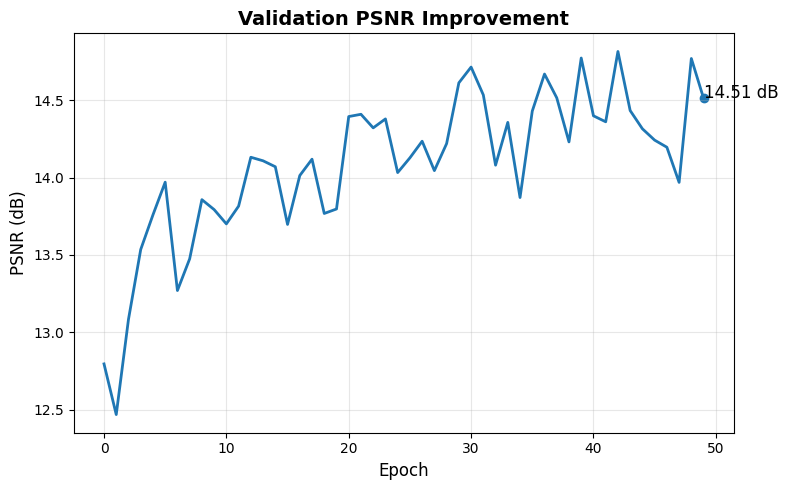

In [51]:
plt.figure(figsize=(8,5))
plt.plot(val_psnrs, linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.title("Validation PSNR Improvement", fontsize=14, fontweight="bold")

plt.scatter(len(val_psnrs)-1, val_psnrs[-1])
plt.text(len(val_psnrs)-1, val_psnrs[-1],
         f"{val_psnrs[-1]:.2f} dB",
         fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

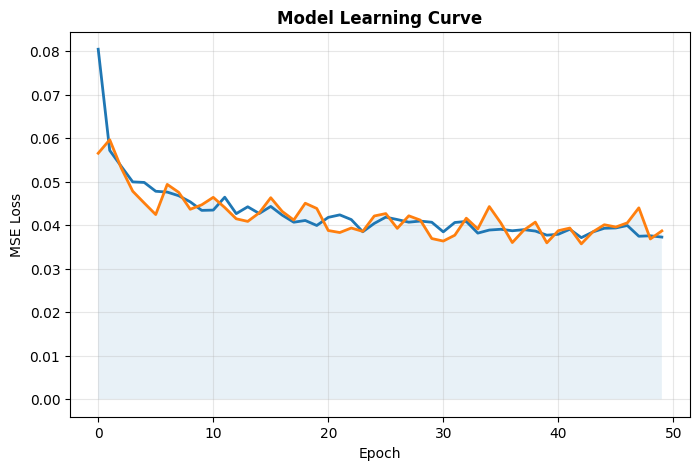

In [52]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, linewidth=2)
plt.plot(val_losses, linewidth=2)
plt.fill_between(range(len(val_losses)), val_losses, alpha=0.1)
plt.title("Model Learning Curve", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(alpha=0.3)
plt.show()

In [53]:
oli_batch, tirs_batch = get_batch(val_files, 1)
pred = model(oli_batch)
import mlx.core as mx

gt = mx.array(tirs_batch[0])
pr = mx.array(pred[0])

gt = np.array(gt)
pr = np.array(pr)


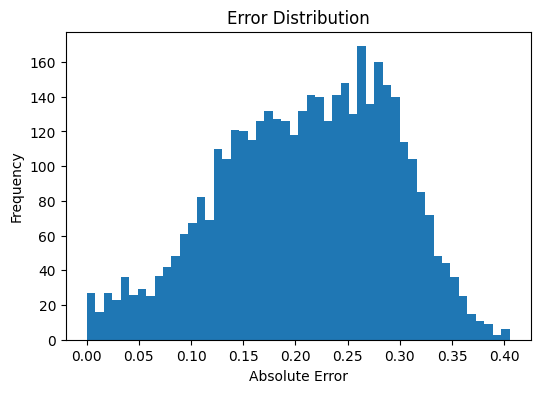

In [54]:
error_map = np.abs(gt[:,:,0] - pr[:,:,0])

plt.figure(figsize=(6,4))
plt.hist(error_map.flatten(), bins=50)
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()

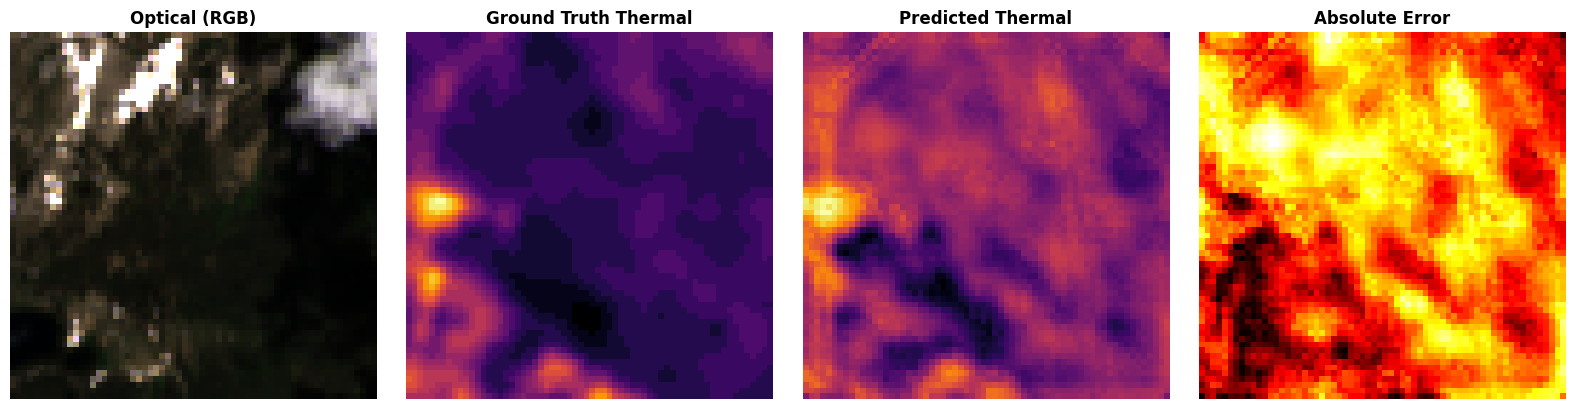

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Create RGB composite (adjust band indices if needed)
rgb = oli[:, :, [3,2,1]]  # example bands
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

error_map = np.abs(gt[:,:,0] - pr[:,:,0])

plt.figure(figsize=(16,4))


plt.subplot(1,4,1)
plt.imshow(rgb)
plt.title("Optical (RGB)", fontweight="bold")
plt.axis("off")


plt.subplot(1,4,2)
plt.imshow(gt[:,:,0], cmap="inferno")
plt.title("Ground Truth Thermal", fontweight="bold")
plt.axis("off")


plt.subplot(1,4,3)
plt.imshow(pr[:,:,0], cmap="inferno")
plt.title("Predicted Thermal", fontweight="bold")
plt.axis("off")


plt.subplot(1,4,4)
plt.imshow(error_map, cmap="hot")
plt.title("Absolute Error", fontweight="bold")
plt.axis("off")

plt.tight_layout()
plt.show()


In [56]:
oli_batch, tirs_batch = get_batch(val_files, 1)
pred = model(oli_batch)

gt = np.array(tirs_batch[0])
pr = np.array(pred[0])
oli = np.array(oli_batch[0])


In [57]:
vmin = min(gt[:,:,0].min(), pr[:,:,0].min())
vmax = max(gt[:,:,0].max(), pr[:,:,0].max())

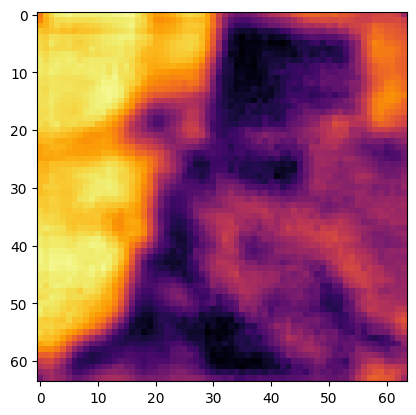

In [58]:
plt.imshow(gt[:,:,0], cmap="inferno", vmin=vmin, vmax=vmax)
plt.imshow(pr[:,:,0], cmap="inferno", vmin=vmin, vmax=vmax)

In [59]:
error_map = np.abs(gt[:,:,0] - pr[:,:,0])

print("Error min:", error_map.min())
print("Error max:", error_map.max())
print("Error mean:", error_map.mean())

Error min: 0.00023447722
Error max: 0.38932258
Error mean: 0.12043467


In [61]:
print("GT range:", gt[:,:,0].min(), gt[:,:,0].max())
print("PR range:", pr[:,:,0].min(), pr[:,:,0].max())


GT range: 0.0 0.983871
PR range: -0.021798959 0.96748793


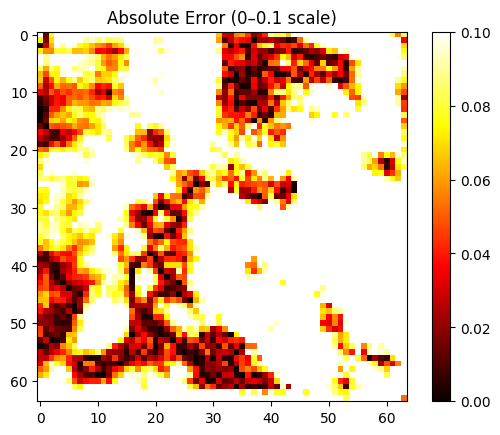

In [62]:
plt.imshow(error_map, cmap="hot", vmin=0, vmax=0.1)
plt.colorbar()
plt.title("Absolute Error (0–0.1 scale)")
plt.show()